In [0]:
import seaborn as sns
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers.core import Activation
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [0]:
df = pd.read_csv('dataset.csv')

In [0]:
df.describe()

,Var3,Var4a,Var4b,Var4c,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Ex.KLD Dryer
count,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.0000,4448.000000,4448.000000
mean,0.792716,0.777428,0.120953,0.101619,78.763923,7.573860,66.374379,6.244532,70.066437,3.649737,68.680634,15.4529,13.656862,14.785049
std,0.405406,0.416020,0.326110,0.302180,1.983451,10.669672,1.011967,8.076033,3.300794,1.026441,11.172692,3.9259,0.498061,0.603504
min,0.000000,0.000000,0.000000,0.000000,73.360000,0.370000,53.850000,0.000000,61.480000,1.140000,34.550000,3.7400,9.770000,13.030000
25%,1.000000,1.000000,0.000000,0.000000,77.610000,1.140000,65.757500,1.240000,67.800000,2.980000,60.360000,12.3500,13.330000,14.340000
50%,1.000000,1.000000,0.000000,0.000000,78.830000,1.480000,66.370000,1.545000,70.430000,3.470000,70.870000,15.2800,13.640000,14.750000
75%,1.000000,1.000000,0.000000,0.000000,79.970000,15.292500,66.880000,12.532500,72.190000,4.180000,77.570000,18.5725,13.970000,15.170000
max,1.000000,1.000000,1.000000,1.000000,96.890000,86.220000,71.570000,39.680000,78.880000,14.370000,91.670000,25.4200,15.560000,16.730000


## EDA

Total number of variables – 13
Total number of Data points – 4442

**Features**:

- Var1 – Type of Raw material mix: Different material mix have different moisture retention capabilities. There are around 30 such variants in the data set
- Var2 – Date of product manufacturing : Required to build a time series model
- Var3 – Categorical variable (0/1)
- Var4 – Number of days of stay of substance in storage area
- Var5 – Storage area Temperature mean-
- Var6 -  Storage area Temperature SD
- Var7 – Storage area RH mean 
- Var8 – Storage area RH SD
- Var9 – Ambient Temperature mean
- Var10 – Ambient Temperature SD
- Var11 – Ambient RH mean
- Var12 – Ambient RH SD
- Var13 – Product Moisture (Ex-Packer Moisture)

**Target**: Dryer Exit Moisture

In [0]:
df.head(10)

,Var1,Var2,Var3,Var4a,Var4b,Var4c,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Ex.KLD Dryer
0,BER,03/01/2018,1,1,0,0,79.39,1.29,65.76,1.48,65.48,4.73,61.98,15.40,12.97,14.77
1,BER,03/01/2018,1,1,0,0,79.18,1.40,65.72,1.45,64.94,4.80,61.46,15.64,12.97,14.77
2,BER,03/01/2018,1,1,0,0,78.73,1.45,66.00,1.48,64.13,4.80,60.21,16.14,12.35,14.77
3,BHT,26/02/2018,1,0,0,1,79.63,13.60,66.22,11.26,72.77,5.47,55.55,21.54,12.60,15.43
4,BHT,26/02/2018,1,0,0,1,79.66,13.49,66.23,11.17,72.78,5.45,55.77,21.52,13.42,15.43
5,CA,10/01/2018,1,0,1,0,79.04,21.42,66.33,17.98,66.59,5.28,59.25,19.04,13.22,14.47
6,CA,10/01/2018,1,0,1,0,78.79,18.71,66.43,15.78,65.55,5.53,58.65,19.93,12.21,14.47
7,CJQ,01/01/2018,1,1,0,0,79.00,1.47,65.93,1.47,65.75,4.55,62.75,16.23,13.43,14.10
8,CJQ,01/01/2018,1,1,0,0,78.83,1.51,66.03,1.46,65.21,4.77,62.15,16.40,13.57,14.10
9,CRK,02/01/2018,1,1,0,0,78.98,1.35,66.29,1.49,67.86,3.03,67.05,17.19,13.65,14.27


In [0]:
# Changine the column header acc"ordingly
df.rename(columns={'Var1':'Raw_Material','Var2':'Date_of_Man','Var3':'Categories','Var4a':'Week_1','Var4b':'Week_2','Var4c':'Week_3',
                         'Var5':'Stor_temp_mean','Var6':'Stor_temp_sd','Var7':'Stor_RH_mean','Var8':'Stor_RH_sd','Var9':'Amb_temp_mean',
                         'Var10': 'Amb_temp_sd','Var11':'Amb_RH_mean','Var12':'Amb_RH_sd','Var13':'Product_Moist','Ex.KLD Dryer':'Target'},inplace=True)
df.head(10)

,Raw_Material,Date_of_Man,Categories,Week_1,Week_2,Week_3,Stor_temp_mean,Stor_temp_sd,Stor_RH_mean,Stor_RH_sd,Amb_temp_mean,Amb_temp_sd,Amb_RH_mean,Amb_RH_sd,Product_Moist,Target
0,BER,03/01/2018,1,1,0,0,79.39,1.29,65.76,1.48,65.48,4.73,61.98,15.40,12.97,14.77
1,BER,03/01/2018,1,1,0,0,79.18,1.40,65.72,1.45,64.94,4.80,61.46,15.64,12.97,14.77
2,BER,03/01/2018,1,1,0,0,78.73,1.45,66.00,1.48,64.13,4.80,60.21,16.14,12.35,14.77
3,BHT,26/02/2018,1,0,0,1,79.63,13.60,66.22,11.26,72.77,5.47,55.55,21.54,12.60,15.43
4,BHT,26/02/2018,1,0,0,1,79.66,13.49,66.23,11.17,72.78,5.45,55.77,21.52,13.42,15.43
5,CA,10/01/2018,1,0,1,0,79.04,21.42,66.33,17.98,66.59,5.28,59.25,19.04,13.22,14.47
6,CA,10/01/2018,1,0,1,0,78.79,18.71,66.43,15.78,65.55,5.53,58.65,19.93,12.21,14.47
7,CJQ,01/01/2018,1,1,0,0,79.00,1.47,65.93,1.47,65.75,4.55,62.75,16.23,13.43,14.10
8,CJQ,01/01/2018,1,1,0,0,78.83,1.51,66.03,1.46,65.21,4.77,62.15,16.40,13.57,14.10
9,CRK,02/01/2018,1,1,0,0,78.98,1.35,66.29,1.49,67.86,3.03,67.05,17.19,13.65,14.27


### Swap columns

In [0]:
# Changing the dataframe order
df = df[['Date_of_Man','Raw_Material', 'Categories', 'Week_1', 'Week_2', 'Week_3', 'Stor_temp_mean', 'Stor_temp_sd', 'Stor_RH_mean', 'Stor_RH_sd', 'Amb_temp_mean', 'Amb_temp_sd', 'Amb_RH_mean', 'Amb_RH_sd', 'Product_Moist', 'Target']]

# Sorting the dataframe by Date
df['Date_of_Man'] = pd.to_datetime(df.Date_of_Man)
df = df.sort_values(by='Date_of_Man')
df=df.reset_index()
df=df.drop(['index'],axis=1)


df.tail(10)

,Date_of_Man,Raw_Material,Categories,Week_1,Week_2,Week_3,Stor_temp_mean,Stor_temp_sd,Stor_RH_mean,Stor_RH_sd,Amb_temp_mean,Amb_temp_sd,Amb_RH_mean,Amb_RH_sd,Product_Moist,Target
4438,2018-12-01,TF,1,1,0,0,78.92,1.60,66.14,1.35,67.93,5.27,58.31,18.14,13.16,14.24
4439,2018-12-01,WFP,1,1,0,0,78.92,1.60,66.14,1.35,67.93,5.27,58.31,18.14,13.60,14.39
4440,2018-12-01,WFP,1,1,0,0,78.29,1.19,66.07,1.27,69.40,4.15,61.71,11.70,13.58,14.39
4441,2018-12-02,CJQ,1,1,0,0,78.09,1.55,65.49,1.09,68.98,3.66,61.30,20.25,13.19,14.99
4442,2018-12-02,CRK,1,1,0,0,78.51,1.61,65.08,0.93,69.05,3.53,59.86,20.09,12.82,14.84
4443,2018-12-02,WFP,1,1,0,0,78.09,1.55,65.49,1.09,68.98,3.66,61.30,20.25,13.63,14.62
4444,2018-12-02,YTMZ,1,1,0,0,77.91,1.54,65.80,1.26,69.14,3.84,62.24,20.04,13.35,14.91
4445,2018-12-02,YTMZ,1,1,0,0,77.71,1.51,65.73,1.35,68.63,4.07,59.59,21.28,13.04,14.91
4446,2018-12-07,YT,1,1,0,0,79.20,0.87,66.74,1.53,70.47,2.38,81.74,9.25,13.04,15.42
4447,2018-12-07,YT,1,1,0,0,79.26,0.88,67.00,1.37,70.58,2.31,82.33,9.42,13.30,15.42


## Null value analysis

In [0]:
df.isnull().any()

Date_of_Man       False
Raw_Material      False
Categories        False
Week_1            False
Week_2            False
Week_3            False
Stor_temp_mean    False
Stor_temp_sd      False
Stor_RH_mean      False
Stor_RH_sd        False
Amb_temp_mean     False
Amb_temp_sd       False
Amb_RH_mean       False
Amb_RH_sd         False
Product_Moist     False
Target            False
dtype: bool

## EDA

In [0]:
df['Date_of_Man'].value_counts()

2018-01-18    28
2015-09-16    26
2017-11-15    23
2015-12-17    22
2015-12-18    21
2015-10-20    21
2016-08-02    21
2015-11-21    21
2018-01-13    20
2017-11-10    20
2017-11-14    20
2017-12-21    20
2015-12-26    20
2018-02-01    19
2017-05-12    19
2018-06-01    19
2018-01-17    19
2018-05-02    18
2018-01-20    18
2017-10-10    18
2015-10-19    18
2015-09-11    17
2018-01-16    17
2015-10-12    17
2018-01-23    17
2018-01-21    17
2018-04-01    17
2016-05-28    16
2015-09-27    16
2015-12-15    16
              ..
2018-06-14     1
2015-04-30     1
2016-04-27     1
2015-06-18     1
2015-04-29     1
2016-04-01     1
2017-06-20     1
2015-03-09     1
2015-05-27     1
2017-07-23     1
2016-12-01     1
2016-01-13     1
2016-05-23     1
2015-12-05     1
2016-02-24     1
2015-08-06     1
2016-03-09     1
2016-11-21     1
2015-05-10     1
2017-06-13     1
2016-12-13     1
2016-10-19     1
2016-04-20     1
2016-05-26     1
2017-07-07     1
2016-02-15     1
2016-02-12     1
2016-07-26    

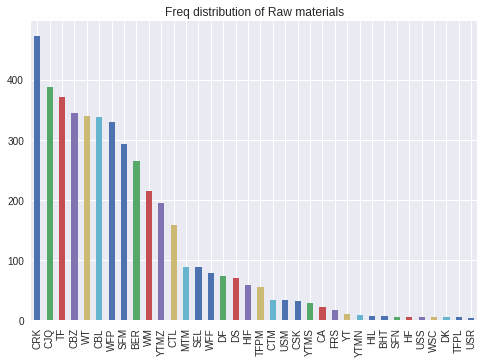

In [0]:
df['Raw_Material'].value_counts().plot.bar(title='Freq distribution of Raw materials')  

1    3526
0     922
Name: Categories, dtype: int64


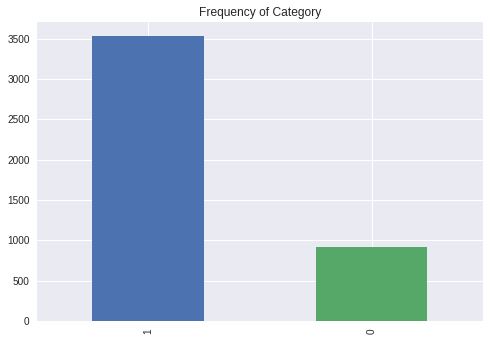

In [0]:
print(df['Categories'].value_counts())
df['Categories'].value_counts().plot.bar(title='Frequency of Category')

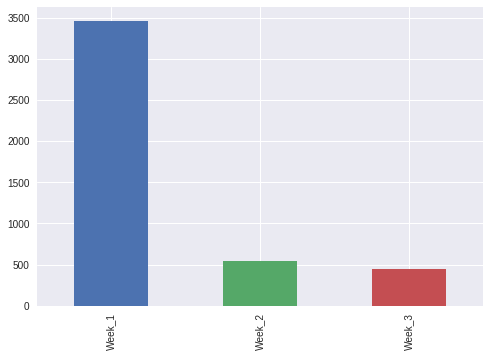

In [0]:
df[['Week_1', 'Week_2', 'Week_3']].sum().plot.bar() 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


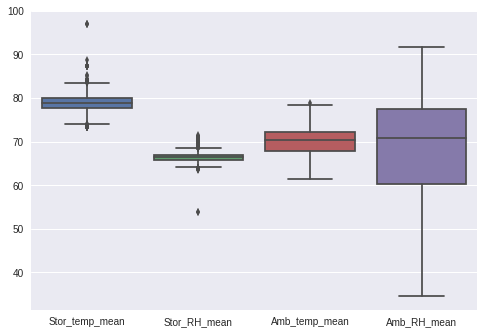

In [0]:
# Boxplot for Storage and Ambient Temp Mean
sns.boxplot(data=df.loc[:,["Stor_temp_mean","Stor_RH_mean","Amb_temp_mean","Amb_RH_mean"]])

Text(0, 0.5, 'Frequency')

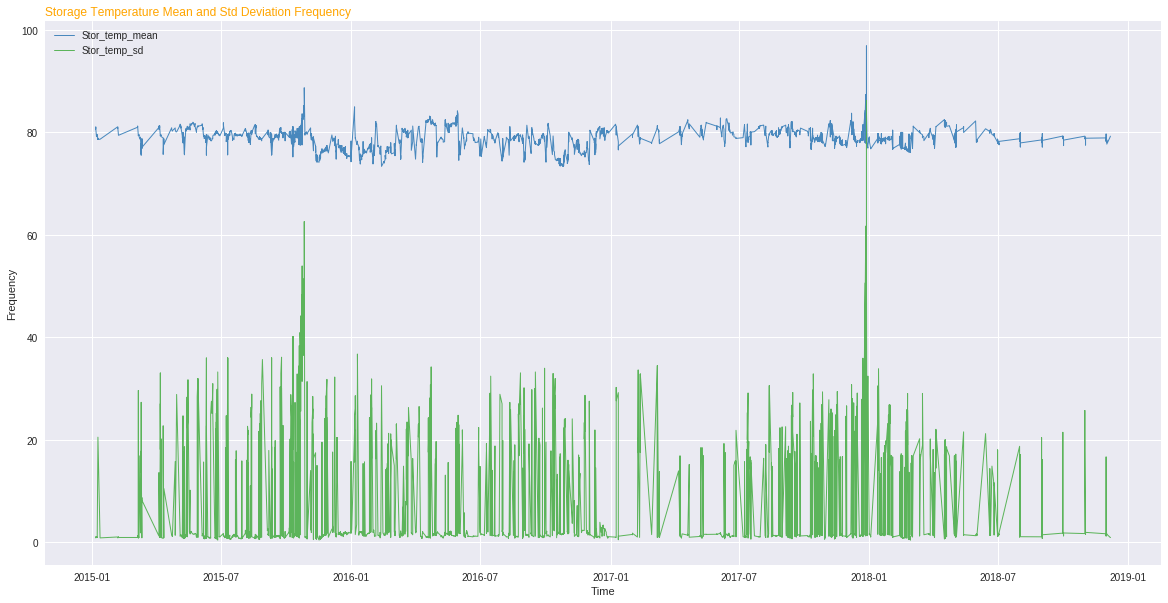

In [0]:
# Store temp mean and std visualiation
plt.figure(figsize=(20,10))
plt.style.use('seaborn-darkgrid')

palette = plt.get_cmap('Set1')

columns=["Stor_temp_mean","Stor_temp_sd"]
num=0
for i in columns:
  num+=1
  plt.plot(df['Date_of_Man'],df[i],marker=" ",color=palette(num),linewidth=1,alpha=0.9,label=i)
  
#plt.legend()
plt.legend(loc=2,ncol=1)

# Add titles
plt.title("Storage Temperature Mean and Std Deviation Frequency ", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Frequency")


Text(0, 0.5, 'Frequency')

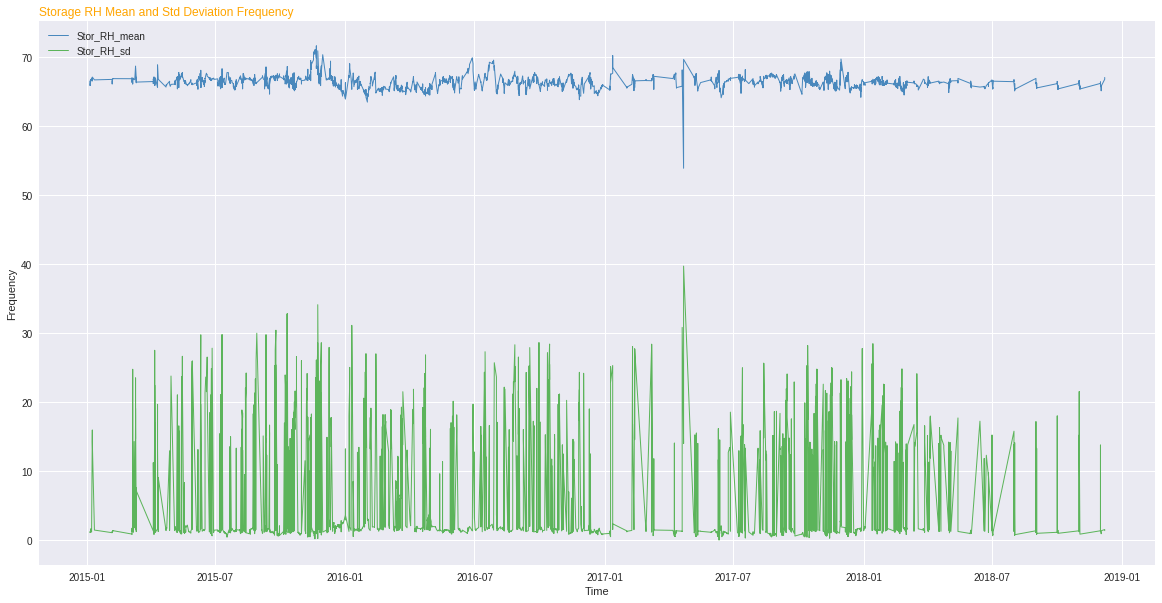

In [0]:
# Store RH mean and std visualiation
plt.figure(figsize=(20,10))
plt.style.use('seaborn-darkgrid')

palette = plt.get_cmap('Set1')

columns=["Stor_RH_mean","Stor_RH_sd"]
num=0
for i in columns:
  num+=1
  plt.plot(df['Date_of_Man'],df[i],marker=" ",color=palette(num),linewidth=1,alpha=0.9,label=i)
  
#plt.legend()
plt.legend(loc=2,ncol=1)

# Add titles
plt.title("Storage RH Mean and Std Deviation Frequency ", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Frequency")

Text(0, 0.5, 'Value')

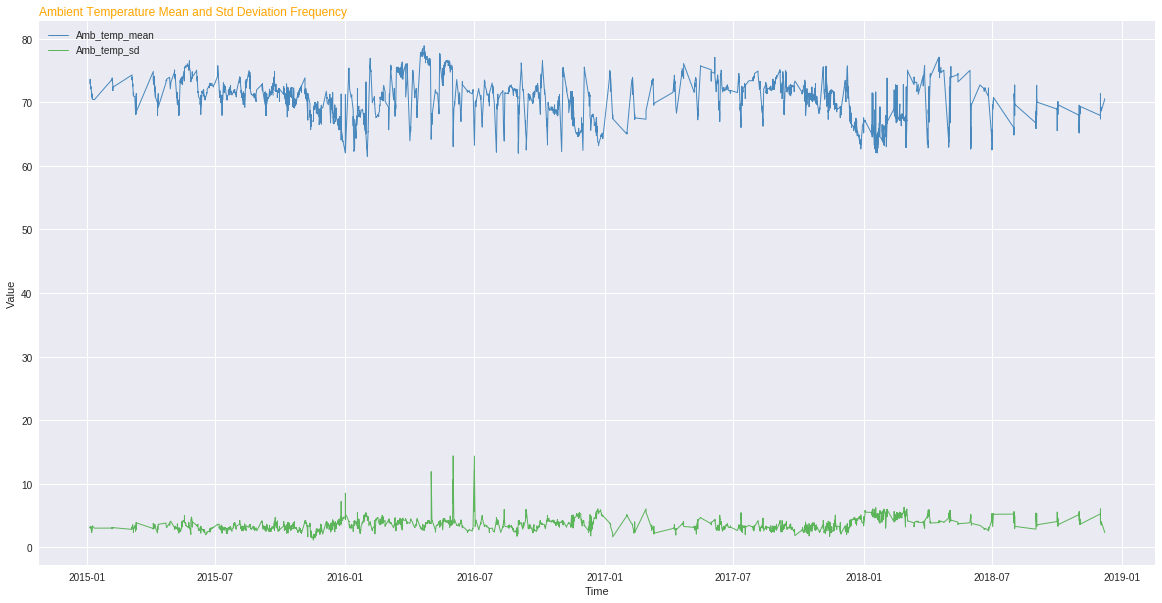

In [0]:
# Amb Temperature mean and std visualiation
plt.figure(figsize=(20,10))
plt.style.use('seaborn-darkgrid')

palette = plt.get_cmap('Set1')

columns=["Amb_temp_mean","Amb_temp_sd"]
num=0
for i in columns:
  num+=1
  plt.plot(df['Date_of_Man'],df[i],marker=" ",color=palette(num),linewidth=1,alpha=0.9,label=i)
  
#plt.legend()
plt.legend(loc=2,ncol=1)

# Add titles
plt.title("Ambient Temperature Mean and Std Deviation Frequency ", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

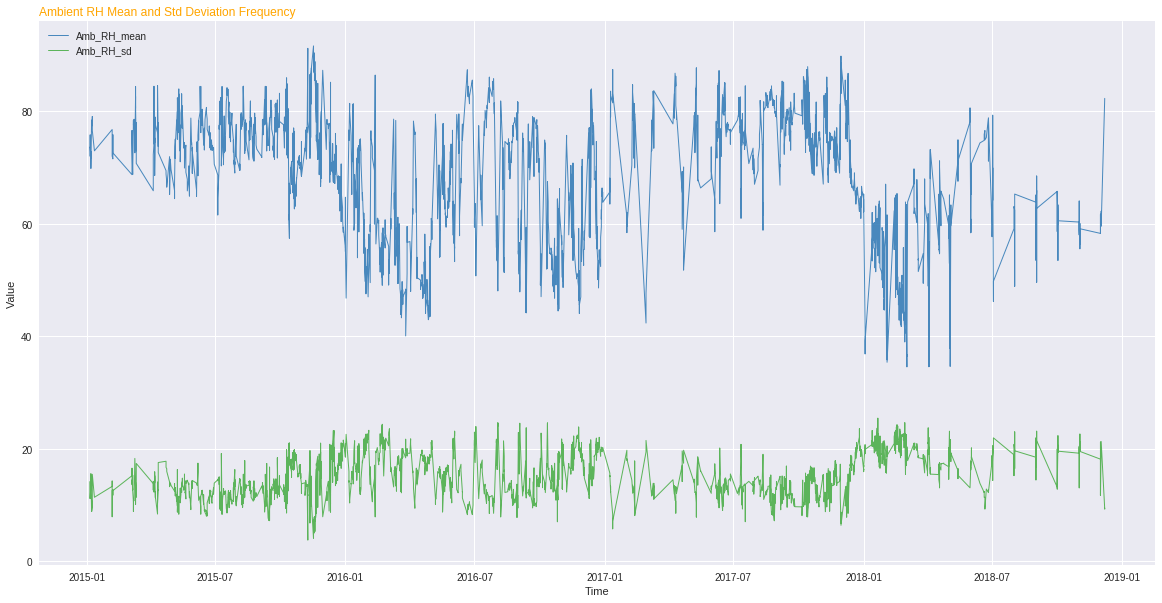

In [0]:
# Store RH mean and std visualiation
plt.figure(figsize=(20,10))
plt.style.use('seaborn-darkgrid')

palette = plt.get_cmap('Set1')

columns=["Amb_RH_mean","Amb_RH_sd"]
num=0
for i in columns:
  num+=1
  plt.plot(df['Date_of_Man'],df[i],marker=" ",color=palette(num),linewidth=1,alpha=0.9,label=i)
  
#plt.legend()
plt.legend(loc=2,ncol=1)

# Add titles
plt.title("Ambient RH Mean and Std Deviation Frequency ", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Value")

Text(0, 0.5, 'Frequency')

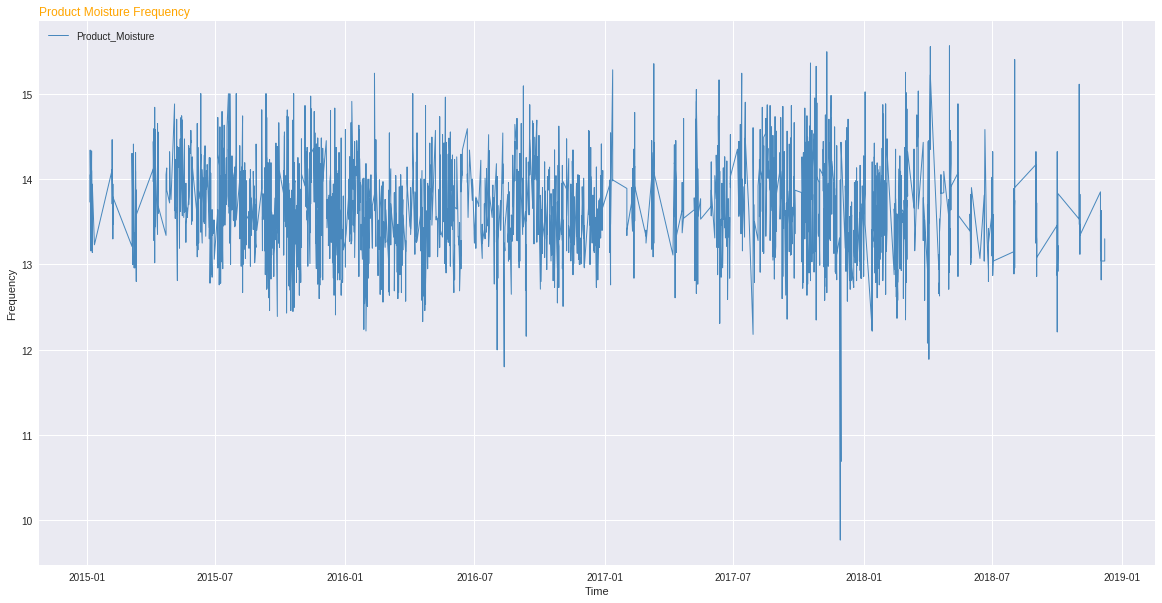

In [0]:
# Dry Moisture Plot
plt.figure(figsize=(20,10))
plt.style.use('seaborn-darkgrid')

palette = plt.get_cmap('Set1')


plt.plot(df['Date_of_Man'],df['Product_Moist'],marker=" ",color=palette(1),linewidth=1,alpha=0.9,label='Product_Moisture')
  
#plt.legend()
plt.legend(loc=2,ncol=1)

# Add titles
plt.title("Product Moisture Frequency ", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Frequency")

Text(0, 0.5, 'Value')

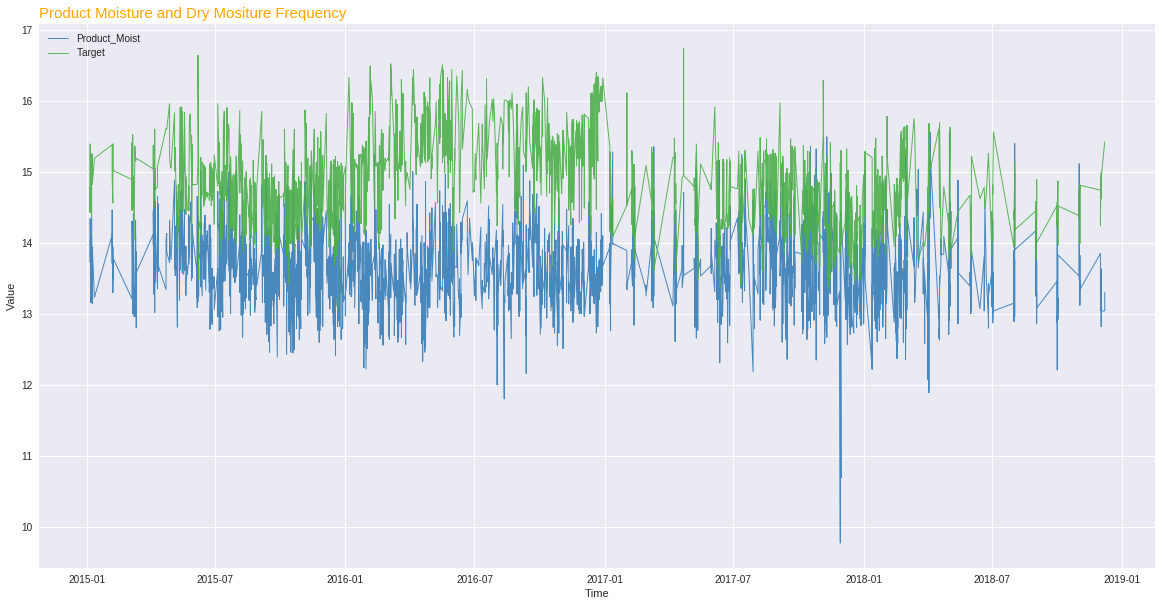

In [0]:
# Product Moisture and Dry Mositure Frequency
plt.figure(figsize=(20,10))
plt.style.use('seaborn-darkgrid')

palette = plt.get_cmap('Set1')

columns=["Product_Moist","Target"]
num=0
for i in columns:
  num+=1
  plt.plot(df['Date_of_Man'],df[i],marker=" ",color=palette(num),linewidth=1,alpha=0.9,label=i)
  
#plt.legend()
plt.legend(loc=2,ncol=1)

# Add titles
plt.title("Product Moisture and Dry Mositure Frequency ", loc='left', fontsize=15, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Value")

Text(0, 0.5, 'Frequency')

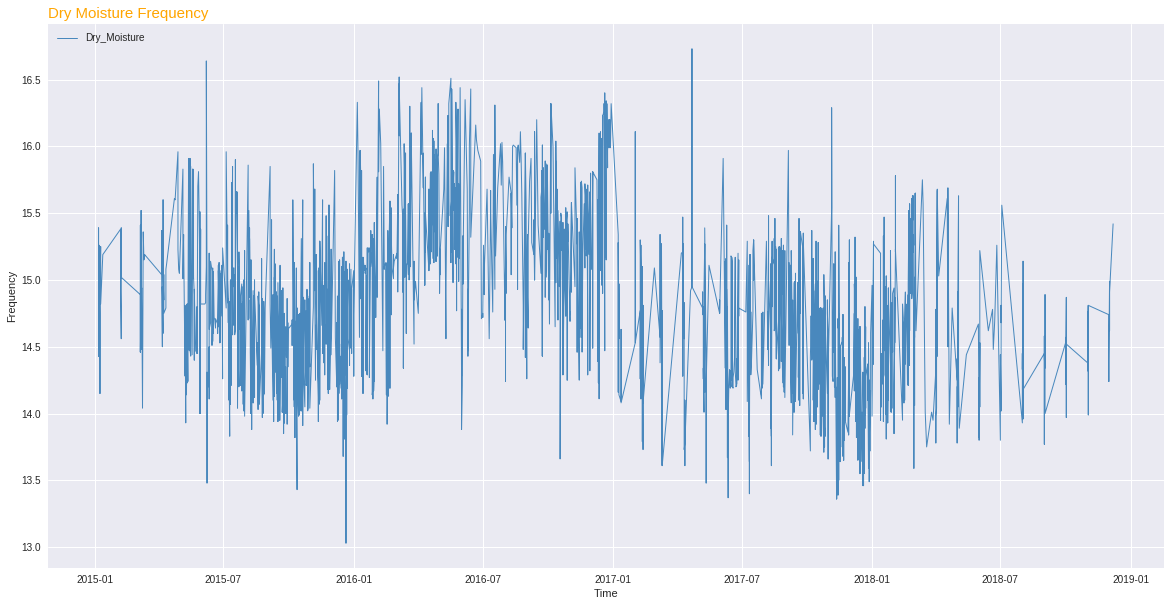

In [0]:
# Product Moistrure Plot
plt.figure(figsize=(20,10))
plt.style.use('seaborn-darkgrid')

palette = plt.get_cmap('Set1')


plt.plot(df['Date_of_Man'],df['Target'],marker=" ",color=palette(1),linewidth=1,alpha=0.9,label='Dry_Moisture')
  
#plt.legend()
plt.legend(loc=2,ncol=1)

# Add titles
plt.title("Dry Moisture Frequency ", loc='left', fontsize=15, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Frequency")

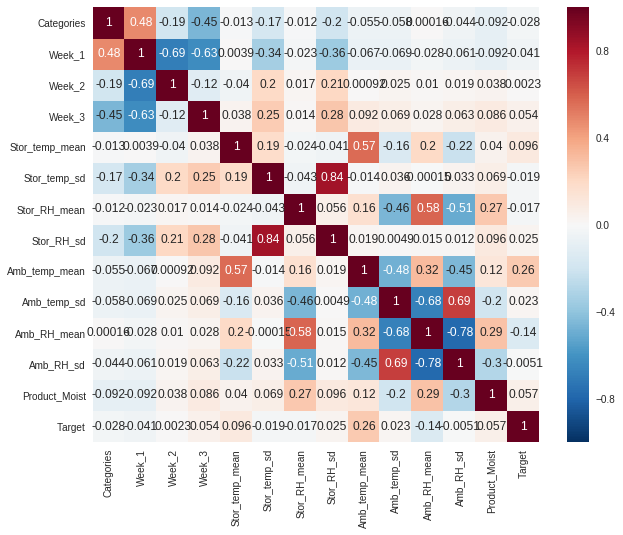

In [0]:
### Correaltion of Features
f,ax = plt.subplots(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr,
            annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values )

In [0]:
df.columns

Index(['Date_of_Man', 'Raw_Material', 'Categories', 'Week_1', 'Week_2',
       'Week_3', 'Stor_temp_mean', 'Stor_temp_sd', 'Stor_RH_mean',
       'Stor_RH_sd', 'Amb_temp_mean', 'Amb_temp_sd', 'Amb_RH_mean',
       'Amb_RH_sd', 'Product_Moist', 'Target'],
      dtype='object')

In [0]:
# model_df for training
model_df=df[['Date_of_Man', 'Raw_Material', 'Categories', 'Week_1', 'Week_2',
       'Week_3', 'Stor_temp_mean', 'Stor_temp_sd', 'Stor_RH_mean',
       'Stor_RH_sd', 'Amb_temp_mean', 'Amb_temp_sd', 'Amb_RH_mean',
       'Amb_RH_sd', 'Product_Moist', 'Target']]

# Label Encoding the Raw_Material
lb_make = LabelEncoder()
model_df["Raw_Material"]=lb_make.fit_transform(model_df["Raw_Material"])

all_df = model_df.copy()
all_df.drop("Date_of_Man",axis=1)


# drop non-value columns
model_df=model_df.drop("Date_of_Man",axis=1)
model_df=model_df.drop("Stor_temp_mean",axis=1)
model_df=model_df.drop("Stor_temp_sd",axis=1)
model_df=model_df.drop("Stor_RH_mean",axis=1)
model_df=model_df.drop("Stor_RH_sd",axis=1)

model_df.head(5)

,Raw_Material,Categories,Week_1,Week_2,Week_3,Amb_temp_mean,Amb_temp_sd,Amb_RH_mean,Amb_RH_sd,Product_Moist,Target
0,31,1,1,0,0,72.95,3.14,73.69,11.12,14.05,14.79
1,3,1,1,0,0,73.62,3.05,74.20,13.43,14.17,14.43
2,3,1,1,0,0,73.40,3.11,75.83,13.45,13.73,14.43
3,3,1,1,0,0,73.26,3.19,75.15,14.16,14.03,14.43
4,0,1,1,0,0,72.95,3.14,73.69,11.12,14.32,15.39


In [0]:
def Normalize(df):
  scaler = MinMaxScaler()
  df['Raw_Material']=scaler.fit_transform(df.Raw_Material.values.reshape(-1,1))
  df['Amb_temp_mean']=scaler.fit_transform(df.Amb_temp_mean.values.reshape(-1,1))
  df['Amb_temp_sd']=scaler.fit_transform(df.Amb_temp_sd.values.reshape(-1,1))
  df['Amb_RH_mean']=scaler.fit_transform(df.Amb_RH_mean.values.reshape(-1,1))
  df['Amb_RH_sd']=scaler.fit_transform(df.Amb_RH_sd.values.reshape(-1,1))
  df['Product_Moist']=scaler.fit_transform(df.Product_Moist.values.reshape(-1,1))
  df['Target']=scaler.fit_transform(df.Target.values.reshape(-1,1))
  
  return df
  
# Normalization
temp_df=model_df.copy()
norm_df=Normalize(temp_df)
norm_df.describe()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Raw_Material,Categories,Week_1,Week_2,Week_3,Amb_temp_mean,Amb_temp_sd,Amb_RH_mean,Amb_RH_sd,Product_Moist,Target
count,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000,4448.000000
mean,0.432920,0.792716,0.777428,0.120953,0.101619,0.493473,0.189700,0.597525,0.540263,0.671306,0.474338
std,0.321290,0.405406,0.416020,0.326110,0.302180,0.189701,0.077584,0.195600,0.181084,0.086021,0.163109
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,1.000000,1.000000,0.000000,0.000000,0.363218,0.139078,0.451856,0.397140,0.614853,0.354054
50%,0.385714,1.000000,1.000000,0.000000,0.000000,0.514368,0.176115,0.635854,0.532288,0.668394,0.464865
75%,0.800000,1.000000,1.000000,0.000000,0.000000,0.615517,0.229781,0.753151,0.684156,0.725389,0.578378
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
def load_data(df,seq_len):
  
  data_raw = df.as_matrix()
  data=[]
  
  for index in range(len(data_raw)- seq_len):
    data.append(data_raw[index:index + seq_len])
    
  data = np.array(data)
  # Splitting for training and testing
  total_length=len(data)
  train_size = total_length * 80 // 100

  train = data[:train_size, :]
  test = data[train_size:, :]
  
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  
  return train_X , train_y , test_X , test_y

In [0]:
# seq_len = 20
# # with original dataframe
# train_X,train_y,test_X,test_y = load_data(model_df,seq_len)
# # with normalized dataframe
# #train_X,train_y,test_X,test_y = load_data(norm_df,seq_len)
# print('Train_X Shape:{}'.format(train_X.shape))
# print('Train_Y Shape:{}'.format(train_y.shape))
# print('Test_X Shape:{}'.format(test_X.shape))
# print('Test_Y Shape:{}'.format(test_y.shape))

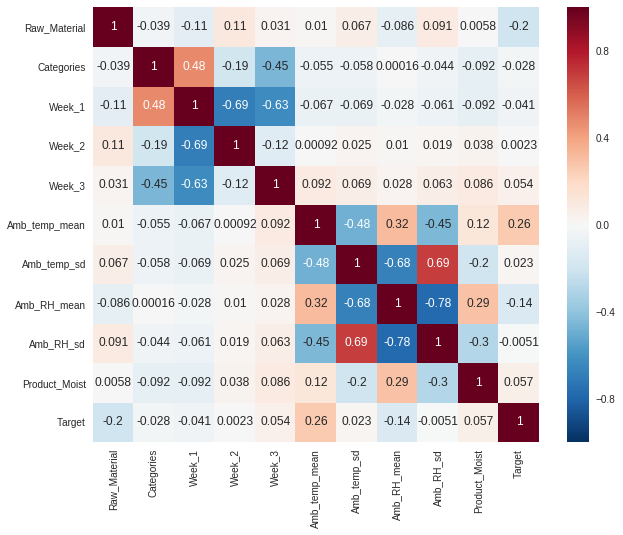

In [0]:
### Correaltion of Features
f,ax = plt.subplots(figsize=(10,8))
corr = norm_df.corr()
sns.heatmap(corr,
            annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values )

In [0]:
# Splitting for training and testing
total_length=len(norm_df)
train_size = total_length * 80 // 100

values=norm_df.as_matrix()
train = values[:train_size, :]
test = values[train_size:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3558, 1, 10) (3558,) (890, 1, 10) (890,)


In [0]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(3558, 1, 10)
(3558,)
(890, 1, 10)
(890,)


In [0]:
train_X

array([[[0.88571429, 1.        , 1.        , ..., 0.68522409,
         0.3404059 , 0.73920553]],

       [[0.08571429, 1.        , 1.        , ..., 0.69415266,
         0.44695572, 0.75993092]],

       [[0.08571429, 1.        , 1.        , ..., 0.72268908,
         0.44787823, 0.68393782]],

       ...,

       [[0.8       , 1.        , 1.        , ..., 0.70185574,
         0.38929889, 0.68566494]],

       [[0.28571429, 1.        , 1.        , ..., 0.74544818,
         0.43450185, 0.64421416]],

       [[0.6       , 1.        , 1.        , ..., 0.72058824,
         0.47416974, 0.57340242]]])

## Stacked LSTM

In [0]:
# Best Model
stop_noimprovement = EarlyStopping(patience=10)
model = Sequential()
model.add(LSTM(200, return_sequences=True, activation='relu', input_shape=(1,10),dropout=0.2))
model.add(LSTM(50, activation='relu',dropout=0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2,callbacks=[stop_noimprovement] ,shuffle=False)

Train on 3558 samples, validate on 890 samples
Epoch 1/50
 - 11s - loss: 0.1352 - acc: 8.4317e-04 - val_loss: 0.1165 - val_acc: 0.0000e+00
Epoch 2/50
 - 5s - loss: 0.1153 - acc: 8.4317e-04 - val_loss: 0.1197 - val_acc: 0.0000e+00
Epoch 3/50
 - 5s - loss: 0.1157 - acc: 8.4317e-04 - val_loss: 0.1157 - val_acc: 0.0000e+00
Epoch 4/50
 - 5s - loss: 0.1148 - acc: 8.4317e-04 - val_loss: 0.1166 - val_acc: 0.0000e+00
Epoch 5/50
 - 5s - loss: 0.1147 - acc: 8.4317e-04 - val_loss: 0.1142 - val_acc: 0.0000e+00
Epoch 6/50
 - 5s - loss: 0.1151 - acc: 8.4317e-04 - val_loss: 0.1143 - val_acc: 0.0000e+00
Epoch 7/50
 - 5s - loss: 0.1148 - acc: 8.4317e-04 - val_loss: 0.1138 - val_acc: 0.0000e+00
Epoch 8/50
 - 5s - loss: 0.1149 - acc: 8.4317e-04 - val_loss: 0.1129 - val_acc: 0.0000e+00
Epoch 9/50
 - 5s - loss: 0.1139 - acc: 8.4317e-04 - val_loss: 0.1262 - val_acc: 0.0000e+00
Epoch 10/50
 - 5s - loss: 0.1142 - acc: 8.4317e-04 - val_loss: 0.1207 - val_acc: 0.0000e+00
Epoch 11/50
 - 5s - loss: 0.1159 - acc: 8

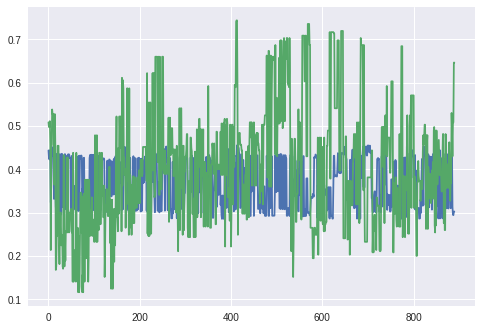

In [0]:
preds=model.predict(test_X)
plt.plot(preds)
plt.plot(test_y)
plt.show()

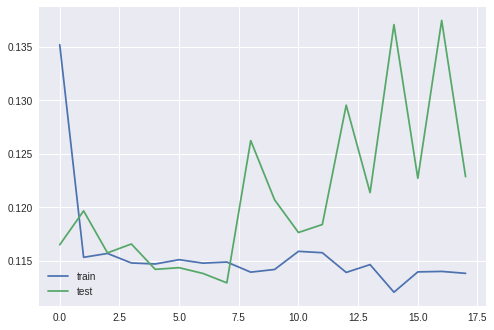

In [0]:


plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()



In [0]:
from sklearn.metrics import mean_absolute_error
# Calculate individual metrics
mean_absolute_error = mean_absolute_error(test_y, preds)
print(mean_absolute_error)
accuracy= 100-(mean_absolute_error/13.5*100)

print("Accuracy:{}".format(accuracy))

0.1122337486010498
Accuracy:99.16863889925148


In [0]:
scaler= MinMaxScaler()
scaler.fit(model_df.Target.reshape(-1,1))
preds_unnorm = scaler.inverse_transform(preds)
test_y_unnorm = scaler.inverse_transform(test_y.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [0]:
# model = Sequential()
# model.add(LSTM(50,input_shape = (1,10)))
# model.add(Dropout(0.5))
# model.add(LSTM(256))
# model.add(Dropout(0.5))
# model.add(Dense(1))
# model.Activation('relu')
# model.compile(loss = 'mae',optimizer = 'adam')
# model.summary()

### GRU MODEL


In [0]:
norm_df

,Raw_Material,Categories,Week_1,Week_2,Week_3,Amb_temp_mean,Amb_temp_sd,Amb_RH_mean,Amb_RH_sd,Product_Moist,Target
0,31,1,1,0,0,0.659195,0.151172,0.685224,0.340406,0.739206,0.475676
1,3,1,1,0,0,0.697701,0.144369,0.694153,0.446956,0.759931,0.378378
2,3,1,1,0,0,0.685057,0.148904,0.722689,0.447878,0.683938,0.378378
3,3,1,1,0,0,0.677011,0.154951,0.710784,0.480627,0.735751,0.378378
4,0,1,1,0,0,0.659195,0.151172,0.685224,0.340406,0.785838,0.637838
5,3,1,1,0,0,0.685057,0.148904,0.656513,0.419742,0.723661,0.378378
6,3,1,1,0,0,0.659195,0.151172,0.685224,0.340406,0.789292,0.378378
7,31,1,1,0,0,0.627586,0.152683,0.650560,0.458948,0.649396,0.397297
8,4,1,1,0,0,0.613218,0.153439,0.670693,0.478321,0.595855,0.597297
9,4,1,1,0,0,0.613218,0.153439,0.670693,0.478321,0.663212,0.586486


In [0]:

from keras.layers.normalization import BatchNormalization
from keras.layers import GRU
# The GRU architecture
model = Sequential()
# First GRU layer with Dropout regularisation
model.add(GRU(units=50, return_sequences=True, input_shape=(1,10), activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# Second GRU layer
model.add(GRU(units=50, return_sequences=True, input_shape=(1,10), activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
# Third GRU layer
model.add(GRU(units=50, return_sequences=True, input_shape=(1,10), activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
# Fourth GRU layer
model.add(GRU(units=50, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))
# Compiling the RNN
model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
model.summary()
# Fitting to the training set
model.fit(train_X,train_y,epochs=50,batch_size=150)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_14 (GRU)                 (None, 1, 50)             9150      
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 50)             200       
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
gru_15 (GRU)                 (None, 1, 50)             15150     
_________________________________________________________________
batch_normalization_6 (Batch (None, 1, 50)             200       
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
gru_16 (GRU)                 (None, 1, 50)             15150     
__________

In [0]:
from sklearn.metrics import mean_absolute_error
# Calculate individual metrics
preds=model.predict(test_X)
mean_absolute_error = mean_absolute_error(test_y, preds)
print(mean_absolute_error)
accuracy= 100-(mean_absolute_error/13.5*100)

print("Accuracy:{}".format(accuracy))

0.11744466048585864
Accuracy:99.1300395519566


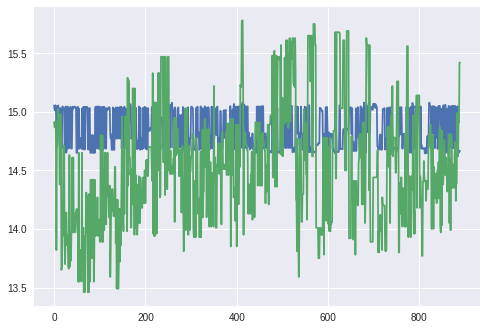

In [0]:

plt.plot(preds_unnorm)
plt.plot(test_y_unnorm)
plt.show()

In [0]:
scaler= MinMaxScaler()
scaler.fit(model_df.Target.reshape(-1,1))
preds_unnorm = scaler.inverse_transform(preds)
test_y_unnorm = scaler.inverse_transform(test_y.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


## New Architecture

In [0]:
model =Sequential()
model.add(LSTM(50,input_shape=(1,10) ,batch_size = 2,return_sequences = True,stateful= True))
model.add(LSTM(50,return_sequences = False,stateful = True))
model.add(Dense(1))
model.compile(loss = 'mae',optimizer ='adam',metrics = ['accuracy'])
history = model.fit(train_X, train_y, epochs=50, batch_size=2, validation_data=(test_X, test_y), verbose=2,shuffle=False)


Train on 3558 samples, validate on 890 samples
Epoch 1/50
 - 25s - loss: 0.1216 - acc: 5.6211e-04 - val_loss: 0.1140 - val_acc: 0.0000e+00
Epoch 2/50
 - 18s - loss: 0.1109 - acc: 5.6211e-04 - val_loss: 0.1135 - val_acc: 0.0000e+00
Epoch 3/50
 - 18s - loss: 0.1075 - acc: 5.6211e-04 - val_loss: 0.1166 - val_acc: 0.0000e+00
Epoch 4/50
 - 18s - loss: 0.1048 - acc: 5.6211e-04 - val_loss: 0.1180 - val_acc: 0.0000e+00
Epoch 5/50
 - 18s - loss: 0.1040 - acc: 5.6211e-04 - val_loss: 0.1217 - val_acc: 0.0000e+00
Epoch 6/50
 - 18s - loss: 0.1034 - acc: 5.6211e-04 - val_loss: 0.1237 - val_acc: 0.0000e+00
Epoch 7/50
 - 18s - loss: 0.1039 - acc: 5.6211e-04 - val_loss: 0.1266 - val_acc: 0.0000e+00
Epoch 8/50
 - 18s - loss: 0.1030 - acc: 5.6211e-04 - val_loss: 0.1285 - val_acc: 0.0000e+00
Epoch 9/50
 - 18s - loss: 0.1026 - acc: 5.6211e-04 - val_loss: 0.1300 - val_acc: 0.0000e+00
Epoch 10/50
 - 18s - loss: 0.1015 - acc: 5.6211e-04 - val_loss: 0.1418 - val_acc: 0.0000e+00
Epoch 11/50
 - 18s - loss: 0.101

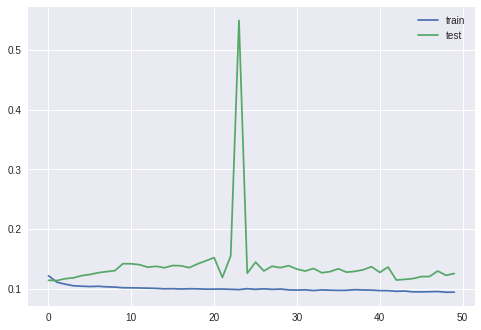

In [0]:


plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()



In [0]:
from sklearn.metrics import mean_absolute_error
# Calculate individual metrics
preds=model.predict(test_X)
mean_absolute_error = mean_absolute_error(test_y, preds)
print(mean_absolute_error)
accuracy= 100-(mean_absolute_error/13.5*100)

print("Accuracy:{}".format(accuracy))

0.11744466048585864
Accuracy:99.1300395519566


In [0]:
# ##OTHER ARCHITECTURE
# from keras.optimizers import Nadam
# from keras.layers.normalization import BatchNormalization
# opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
# print(train_X.shape)
# model = Sequential()
# model.add(LSTM(200,input_shape=(1,10),return_sequences=False, dropout=0.2))
# model.add(BatchNormalization())
# model.add(LSTM(100,input_shape=(1,10), return_sequences=False, dropout=0.2))
# model.add(BatchNormalization())
# model.add(LSTM(100,input_shape=(1,10),return_sequences=False, dropout=0.2))
# model.add(BatchNormalization())
# model.add(Dense(50, activation='softmax', kernel_initializer='glorot_uniform'))
# model.add(Dense(1, activation='softmax', kernel_initializer='glorot_uniform'))
# model.compile(loss='mae', optimizer=opt,metrics=['accuracy'])
# model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2,shuffle=False)
# model.summary()

In [0]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
c=np.array([[0,0],[0,1],[1,1],[3,0]])
k=2 #numNeighbours
clf = LocalOutlierFactor(n_neighbors=k, n_jobs=-1,algorithm='brute',metric='manhattan').fit(c) 
Z = clf.negative_outlier_factor_
print(-Z)
[ 0.875  1.33333333  0.875   2. ]

## Outlier Removal

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [0]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

In [0]:
Load Outlierd DATA
PCA(Creating components)
fit new dataset to custom model
Add Reference of the paper
Hyper Parameter Tuning
reduce the epslon range 
save and load the model